In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import AalenAdditiveFitter
import patsy
import emoji



%matplotlib inline
pd.set_option('display.max_colwidth', -1)

In [77]:
s_names = pd.read_csv("data/resp_id_join.csv")
s_names = s_names[['Respondent ID','First name', 'Last name']]
s_names.columns = ['Respondent ID','first_name', 'last_name']
sr = pd.read_csv("data/survey_joined_anon.csv")
#sr = sr.merge(s_names, how = 'left', on = 'Respondent ID')
ss = pd.read_csv("data/student_ids_survey_clean_3.csv")

# Need respondent ids for those ss-sr join
# ss['first_name'] = [name.split()[0] for name in ss.name]
# ss['last_name'] = [name.split()[1] if len(name.split()) == 2 else 'unknown' for name in ss.name]
# ss['first_name'] = ss['first_name'].str.lower()
# ss['last_name'] = ss['last_name'].str.lower()

#take the not found and opt out from the ss

ss = ss[(ss.respondent_id != 'not found') & (ss.respondent_id != 'opt out')]
ss['respondent_id'] = ss.respondent_id.astype(float)
sr = pd.read_csv("data/sr_data_clean.csv")
sr_user = sr[(pd.notnull(sr['Pre_Q1'])) & (pd.notnull(sr['Post_Q1']))]

ques = pd.read_csv("data/resp_id_join.csv")
question_list = ques.columns[15:53]
question_list2 = question_list.append(question_list)
# sr['first_name'] = sr['first_name'].str.lower()
# sr['last_name'] = sr['last_name'].str.lower()
#45 students here's who's missing  -> ss[-ss.student_id.isin(sr.student_id)]
#and who we have sr[pd.notnull(sr.student_id)]

In [61]:
sr_user.shape

(312, 93)

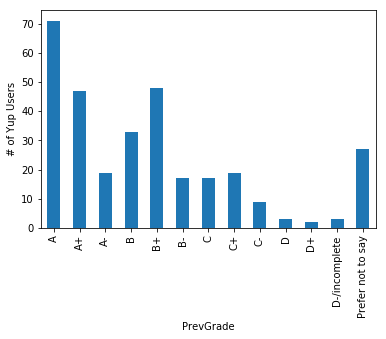

In [56]:
sr_user.groupby('PrevGrade')['ID'].count().plot(kind='bar')
plt.ylabel("# of Yup Users")


* Grading a little skewed high. Maybe something interesting to look at.
* Would need to map to GP.

In [16]:
sr_user[sr_user.Treatment == 0]

,ID,PrevGrade,Section,Treatment,Pre_Q1,Pre_Q2,Pre_Q3,Pre_Q4,Pre_Q5,Pre_Q6,...,Post_Q37,Post_Q38,Post_Q39,Post_Q40,Post_Q41,Post_Q42,User ID,Name,Magic Code,respondent_id
425,5335038789,Prefer not to say,Reis - 814,0,Somewhat agree,Somewhat disagree,Somewhat agree,Disagree,Somewhat disagree,Somewhat disagree,...,Somewhat agree,Somewhat agree,1.0,0.0,0.0,0.0,560191.0,Juliette,NYC2D,5.335039e+09
428,5335048876,A,Reis - 814,0,Somewhat disagree,Strongly Agree,Agree,Agree,Strongly Disagree,Strongly Agree,...,Strongly Agree,Strongly Agree,1.0,1.0,0.0,1.0,560885.0,Sarwan Ansari,NYC2D,5.335049e+09
429,5335036885,A+,Reis - 814,0,Somewhat agree,Strongly Agree,Strongly Agree,Somewhat agree,Strongly Disagree,Somewhat agree,...,Somewhat agree,Agree,1.0,1.0,0.0,1.0,598184.0,Reda Arif,NYC2D,5.335037e+09
432,5335039025,A+,Reis - 814,0,Strongly Agree,Agree,Agree,Agree,Strongly Disagree,Agree,...,Agree,Agree,1.0,1.0,0.0,0.0,565984.0,Elham Chisty,NYC2D,5.335039e+09
435,5335038454,A-,Reis - 814,0,Agree,Agree,Somewhat agree,Agree,Somewhat disagree,Agree,...,Somewhat disagree,Somewhat agree,1.0,1.0,0.0,1.0,567586.0,MethelaNY Farhana,NYC2D,5.335038e+09
442,5335037930,B+,Reis - 814,0,Agree,Somewhat agree,Agree,Agree,Disagree,Agree,...,NaN,NaN,NaN,NaN,NaN,NaN,565991.0,Marqel McCollum,NYC2D,5.335038e+09
446,5335037251,A+,Reis - 814,0,Strongly Agree,Agree,Agree,Strongly Agree,Disagree,Agree,...,Agree,Strongly Agree,1.0,1.0,1.0,1.0,560596.0,Habiba Rahman,NYC2D,5.335037e+09
448,5335039063,C,Reis - 814,0,Somewhat disagree,Somewhat disagree,Somewhat agree,Somewhat disagree,Somewhat disagree,Agree,...,Agree,Disagree,1.0,0.0,0.0,0.0,565994.0,Kaylee Ramos,NYC2D,5.335039e+09
449,5335040153,A+,Reis - 814,0,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Disagree,Agree,...,Strongly Agree,Strongly Agree,1.0,1.0,1.0,0.0,565986.0,Harish Sharma,NYC2D,5.335040e+09


* 9 students not in the treatment used yup

In [36]:
sr_user.groupby('Pre_Q1')['ID'].count()

Pre_Q1
Agree                25
Disagree             4 
Somewhat agree       21
Somewhat disagree    7 
Strongly Agree       15
Strongly Disagree    1 
Name: ID, dtype: int64

Possible questions of interest:
* Q1 => I learn math quickly.
* Q4 => I'm good at Math
Scrap that let's look at what changed and go from there



In [5]:
#0 = opposite growth midnset 1 = growth mindset 2 = base level intelligence/ not related to perceverence
ques_cat =[2,
1,
1,
2,
0,
 
1,
0,
1,
0,
0,

0,
0,
2,
1,
0,
 
2,
2,
2,
0,
2,

1,
1,
2,
0,
0,

1,
2,
2,
0,
0,

2,
1,
0,
2,
2,

1,
1,
1]

In [78]:
# Create agree/ disagree boolean for Q1-42
# Measure which has the most crossover in 


#Pre boolify
for i in range(38):
    i = i+1
    mask_agree = (sr_user['Pre_Q' + str(i)] == 'Agree') | \
(sr_user['Pre_Q' + str(i)] == 'Somewhat agree') | \
(sr_user['Pre_Q' + str(i)] == 'Strongly Agree')

    mask_disagree = (sr_user['Pre_Q' + str(i)] == 'Disagree') | \
(sr_user['Pre_Q' + str(i)] == 'Somewhat disagree') | \
(sr_user['Pre_Q' + str(i)] == 'Strongly Disagree') | \
pd.isnull(sr_user['Pre_Q' + str(i)])
    sr_user.loc[mask_agree, 'Pre_Q' + str(i)] = 1
    sr_user.loc[mask_disagree, 'Pre_Q' + str(i)] = 0
    sr_user['Pre_Q' + str(i)] = sr_user['Pre_Q' + str(i)].astype(int)
    
# Post boolify    
for i in range(38):
    i = i+1
    mask_agree = (sr_user['Post_Q' + str(i)] == 'Agree') | \
(sr_user['Post_Q' + str(i)] == 'Somewhat agree') | \
(sr_user['Post_Q' + str(i)] == 'Strongly Agree')

    mask_disagree = (sr_user['Post_Q' + str(i)] == 'Disagree') | \
(sr_user['Post_Q' + str(i)] == 'Somewhat disagree') | \
(sr_user['Post_Q' + str(i)] == 'Strongly Disagree')| \
pd.isnull(sr_user['Post_Q' + str(i)])
    sr_user.loc[mask_agree, 'Post_Q' + str(i)] = 1
    sr_user.loc[mask_disagree, 'Post_Q' + str(i)] = 0
    sr_user['Post_Q' + str(i)] = sr_user['Post_Q' + str(i)].astype(int)

#Code in scores pre and post
#create column that sums difference between columns
# show if there was a higher average difference in yup users vs. non yup users
# positive diff vs. non-positive diff within users

for i in range(38):
    gm_cat = ques_cat[i]
    i = i+1
    mask_gm = (sr_user['Pre_Q' + str(i)] == gm_cat)                 
    sr_user.loc[mask_gm, 'Pre_Q' + str(i)+ "_gmscore"] = 1
    sr_user.loc[(-mask_gm) & (ques_cat == 2), 'Pre_Q' + str(i)+ '_gmscore'] = 0  
    sr_user.loc[(-mask_gm) & (ques_cat != 2), 'Pre_Q' + str(i)+ '_gmscore'] = -1  
    
for i in range(38):
    gm_cat = ques_cat[i]
    i = i+1
    mask_gm = (sr_user['Post_Q' + str(i)] == gm_cat)                 
    sr_user.loc[mask_gm, 'Post_Q' + str(i)+ "_gmscore"] = 1
    sr_user.loc[(-mask_gm) & (ques_cat == 2), 'Post_Q' + str(i)+ '_gmscore'] = 0  
    sr_user.loc[(-mask_gm) & (ques_cat != 2), 'Post_Q' + str(i)+ '_gmscore'] = -1

print sr_user.columns[-76:-38]
sr_user['Pre_total'] = sr_user[sr_user.columns[-76:-38]].sum(axis=1)
sr_user['Post_total'] = sr_user[sr_user.columns[-39:-1]].sum(axis=1)
sr_user['gm_score_diff'] = sr_user['Post_total'] - sr_user['Pre_total'] 

/Users/ricky/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ricky/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Index([u'Pre_Q1_gmscore', u'Pre_Q2_gmscore', u'Pre_Q3_gmscore',
       u'Pre_Q4_gmscore', u'Pre_Q5_gmscore', u'Pre_Q6_gmscore',
       u'Pre_Q7_gmscore', u'Pre_Q8_gmscore', u'Pre_Q9_gmscore',
       u'Pre_Q10_gmscore', u'Pre_Q11_gmscore', u'Pre_Q12_gmscore',
       u'Pre_Q13_gmscore', u'Pre_Q14_gmscore', u'Pre_Q15_gmscore',
       u'Pre_Q16_gmscore', u'Pre_Q17_gmscore', u'Pre_Q18_gmscore',
       u'Pre_Q19_gmscore', u'Pre_Q20_gmscore', u'Pre_Q21_gmscore',
       u'Pre_Q22_gmscore', u'Pre_Q23_gmscore', u'Pre_Q24_gmscore',
       u'Pre_Q25_gmscore', u'Pre_Q26_gmscore', u'Pre_Q27_gmscore',
       u'Pre_Q28_gmscore', u'Pre_Q29_gmscore', u'Pre_Q30_gmscore',
       u'Pre_Q31_gmscore', u'Pre_Q32_gmscore', u'Pre_Q33_gmscore',
       u'Pre_Q34_gmscore', u'Pre_Q35_gmscore', u'Pre_Q36_gmscore',
       u'Pre_Q37_gmscore', u'Pre_Q38_gmscore'],
      dtype='object')


/Users/ricky/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ricky/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ricky/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

In [47]:
sr_user['gm_score_diff'] = sr_user['Post_total'] - sr_user['Pre_total']

/Users/ricky/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


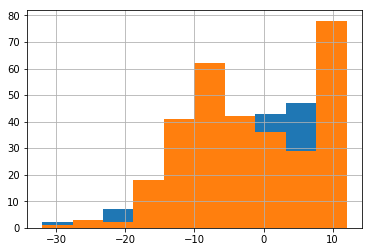

In [79]:
#Proof of concept
sr_user.Pre_total.hist()
sr_user.Post_total.hist()


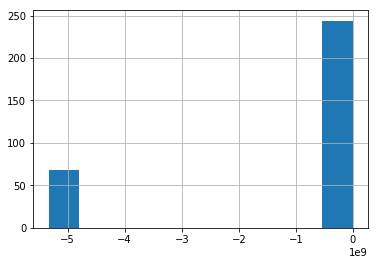

In [74]:
sr_user.loc[]

In [86]:
sr_user.loc[-pd.isnull(sr_user['User ID']), 'user_bool'] = 1
sr_user.loc[pd.isnull(sr_user['User ID']), 'user_bool'] = 0

In [25]:
# ques = pd.read_csv("data/resp_id_join.csv")
# question_list = ques.columns[15:53]

# posi_change =pd.DataFrame(sr_user[sr_user.columns[-76:]].sum())
# posi_change['question'] = question_list2
# posi_change = posi_change.reset_index()
# posi_change.columns = ['response_code','count_change' , 'question']
# posi_change

,response_code,count_change,question
0,change_Q1,4.0,I learn math quickly.
1,change_Q2,1.0,I am a hard worker.
2,change_Q3,3.0,I have overcome setbacks in my math class and learned hard concepts.
3,change_Q4,4.0,I am good at math.
4,change_Q5,5.0,You have a certain amount of intelligence and you really can't do much to change it.
5,change_Q6,1.0,I could benefit from one-on-one math support.
6,change_Q7,4.0,I get very nervous doing math problems.
7,change_Q8,1.0,"No matter how much intelligence you have, you can always change it quite a bit."
8,change_Q9,11.0,I get very tense when I have to do math homework.
9,change_Q10,7.0,I often worry that it will be difficult for me in math class.


In [27]:
posi_change.sort_values(['count_change','response_code'], ascending= False)

,response_code,count_change,question
14,change_Q15,14.0,"When studying for a hard math test, I either give up or only study the easy parts."
71,change_neg_Q34,12.0,I work on math practice problems and exercises even when I don't have to.
29,change_Q30,12.0,"When I take a hard test, I think about how poorly I am doing."
44,change_neg_Q7,11.0,I get very nervous doing math problems.
8,change_Q9,11.0,I get very tense when I have to do math homework.
28,change_Q29,11.0,When my math homework is hard I either give up or only do the easy parts.
24,change_Q25,11.0,Your intelligence is something about you that you can't change very much.
73,change_neg_Q36,10.0,Setbacks don't discourage me. I don't give up easily.
70,change_neg_Q33,10.0,You can learn new things but you can't really change your basic intelligence.
68,change_neg_Q31,10.0,My study skills are excellent compared with others in my math class.


In [89]:
sr_user.groupby('user_bool')[].mean().T

user_bool,0.0,1.0
Unnamed: 0,2.059795e+02,2.266029e+02
ID,5.321139e+09,5.321025e+09
Treatment,4.344262e-01,8.823529e-01
Pre_Q1,7.131148e-01,8.529412e-01
Pre_Q2,8.934426e-01,9.411765e-01
Pre_Q3,9.016393e-01,9.117647e-01
Pre_Q4,7.459016e-01,8.529412e-01
Pre_Q5,3.934426e-01,4.264706e-01
Pre_Q6,8.401639e-01,9.264706e-01
Pre_Q7,4.262295e-01,4.705882e-01


*  Students that chose to use yup answered an average of 1.2 less "gap bridged questions"
* Students that chose not to use yup had a modest change of .1 less gb questions

In [40]:
#Mark students as mindset changers based on all positively correlated questions with 7 or more students
changers_mask_7 = (sr_user["change_neg_Q7"]==1) |\
(sr_user["change_neg_Q33"]==1) |\
(sr_user["change_neg_Q16"]==1) |\
(sr_user["change_neg_Q10"]==1) | \
(sr_user["change_neg_Q25"]==1) | \
(sr_user["change_Q38"]==1) |\
(sr_user["change_Q13"]==1) 

sr_user.loc[changers_mask_7, 'posi_change'] = 1
sr_user.loc[-changers_mask_7, 'posi_change'] = 0

* Top 8 for disagree -> agree
    * Q15= When studying for a hard math test, I either give up or only study the easy parts. 
        * Bad Change
    * Q25= Your intelligence is something about you that you can't change very much. 
        * Bad Change
    * Q9 = I get very tense when I have to do math homework.
        * Bad Change
    * Q30 = When I take a hard test, I think about how poorly I am doing.
        * Bad Change
    * Q29 = When my math homework is hard I either give up or only do the easy parts.
        * Bad Change

    * Q24 = I am so nervous during a math test that I cannot remember facts I have already learned.
        * Bad Change
    * Q19 = To be honest, you can't really change how intelligent you are. 
        * Bad Change
        
  
* Top positive change for disagree ->agree   
    * Q16 = In my math class, I understand even the most difficult concepts. 
        * 8 students
        * not gm
    * Q13 => I have always believed that math is one of my best subjects.
        * 8 students
        * not gm
    * Q20 = I am confident that I can understand graphs presented in newspapers.
        * 7 students
        * not gm
    * Q38 = I finish whatever I begin.
        * 7 students
        * gm
    * Q36 = Setbacks don't discourage me. I don't give up easily.
        * 7 students
        * gm
        
* Top positive change for agree -> disagree
    * Q7 
    Q33 -> You can learn new things but you can't really change your basic intelligence.
        * 10 students
        * gm
    * Q10 -> I often worry that it will be difficult for me in math class.
        * 8 students
        * gm
    * Q25 -> Your intelligence is something about you that you can't change very much.
        * 8 students
        * gm
    * Q9 -> I get very tense when I have to do math homework.
        * 7 students
        * not gm
    * Q11 = I feel helpless when doing a math problem.
        * 7 students
        * gm
        

In [172]:
sr_user['User ID'] = sr_user['User ID'].astype(int)

ValueError: Cannot convert NA to integer

In [123]:
ses.dtypes
#sr_user['User ID'].dtypes

Unnamed: 0                          int64  
session_id                          int64  
tutor_id                            float64
student_id                          int64  
timestamp                           object 
feedback_score                      float64
wait_time                           float64
ended_by_reason                     object 
session_category                    object 
consolidated_session_category       object 
student_complained                  bool   
student_complaint_clarity           bool   
student_complaint_speed             bool   
student_complaint_subject           bool   
student_complaint_other             bool   
session_tag_cheating                bool   
session_tag_inappropriate           bool   
session_tag_other_subject           bool   
session_tag_no_material             bool   
session_tag_student_left            bool   
session_tag_student_not_engaging    bool   
session_tag_used_whiteboard         bool   
student_rating                  

In [180]:
students = pd.read_csv("data/students.csv")
ses = pd.read_csv("data/ses_1_42.csv")
students['student_id'] = students.student_id.astype(int)
sr_join = sr_user[-(pd.isnull(sr_user['User ID']))]
sr_join['User ID'] = sr_join['User ID'].astype(int)
sr_join = sr_join.merge(students, how = 'left', left_on = 'User ID', right_on = 'student_id')
sr_join =  sr_join[-(pd.isnull(sr_join['session_count']))]

/Users/ricky/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


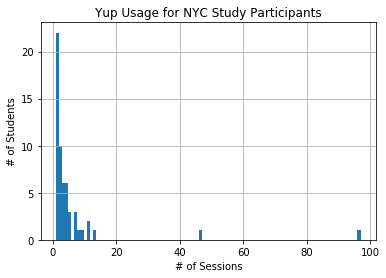

In [206]:
sr_join.session_count.hist(bins=100)
plt.title("Yup Usage for NYC Study Participants")
plt.ylabel("# of Students")
plt.xlabel("# of Sessions")

* We have clear seperation between the two outliers (power users) and the rest of the data set.
* We'll analyze these two groups seperately as the outliers will likely swing any averaging metrics.


In [193]:
sr_join.loc[(sr_join.gm_score_diff > 0) , 'gm_diff_bool'] = 1
sr_join.loc[sr_join.gm_score_diff <= 0, 'gm_diff_bool'] = 0

pwr = sr_join[(sr_join.student_id == 565474.0) | (sr_join.student_id == 563980.0)]
norm = sr_join[(sr_join.student_id != 565474.0) & (sr_join.student_id != 563980.0)]

In [187]:
sr_join?.loc


    session_count   gb_rate PrevGrade
21  47.0           0.553191  B+      
    session_count   gb_rate PrevGrade
14  97.0           0.216495  A-      


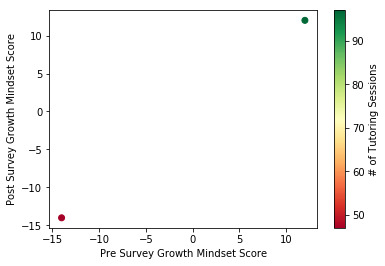

In [158]:
plt.scatter(pwr.Pre_total,pwr.Post_total, c = pwr.session_count, cmap= 'RdYlGn')
plt.xlabel("Pre Survey Growth Mindset Score")
plt.ylabel("Post Survey Growth Mindset Score")
plt.colorbar(label = '# of Tutoring Sessions')
print pwr[pwr.student_id == 565474.0][['session_count', 'gb_rate', 'PrevGrade']]
print pwr[pwr.student_id == 563980.0][['session_count', 'gb_rate', 'PrevGrade']]

* The tail of two users, growth mindsets at different ends of the spectrum.
    * unfortunetly we see stagnation for both.
    * The higher session user did have a growth mindset according to the survey.
        * This user also had a much lower gap bridged rate.
    * The student with the lower session count had a gb rate of 55% (34% higher than the other power user)
    


In [202]:
norm[norm.gm_score_diff<0].shape

(27, 191)

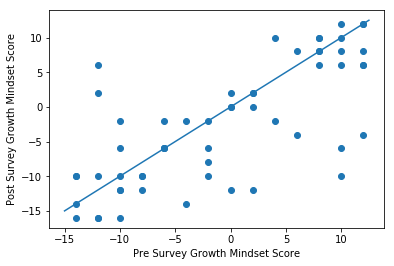

In [200]:
plt.scatter(sr_join.Pre_total,sr_join.Post_total)
plt.plot( [-15,12.5],[-15,12.5] )
plt.xlabel("Pre Survey Growth Mindset Score")
plt.ylabel("Post Survey Growth Mindset Score")

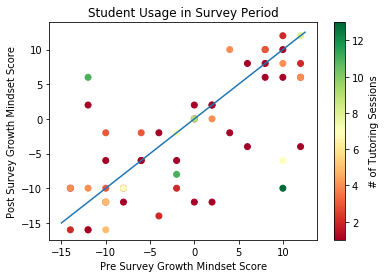

In [203]:
plt.scatter(norm.Pre_total,norm.Post_total, c = norm.session_count, cmap= 'RdYlGn')
plt.plot( [-15,12.5],[-15,12.5] )
plt.xlabel("Pre Survey Growth Mindset Score")
plt.ylabel("Post Survey Growth Mindset Score")
plt.colorbar(label = '# of Tutoring Sessions')
plt.title("Student Usage in Survey Period")

* Very few students showed both improving growth mindset and 
* Even fewer showed that they improved growth mindset and high session counts
* We also did'nt see a correlation between reporting a growth mindset and using Yup. (red dots in top right)



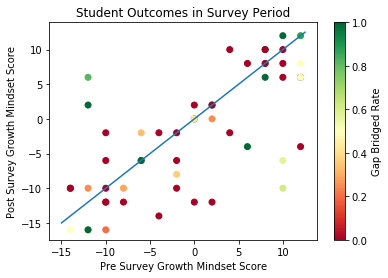

In [204]:
plt.scatter(norm.Pre_total,norm.Post_total, c = norm.gb_rate, cmap= 'RdYlGn')
plt.plot( [-15,12.5],[-15,12.5] )
plt.xlabel("Pre Survey Growth Mindset Score")
plt.ylabel("Post Survey Growth Mindset Score")
plt.colorbar(label = 'Gap Bridged Rate')
plt.title("Student Outcomes in Survey Period")

* Once again a few students are doing better than others, but I wouldn't say there is any pattern to speak of.
* In terms of one offs, we can look at the top left and see a couple students that improved their mindset and had successful sessions.

In [194]:
norm.groupby('gm_diff_bool')[['session_count', 'gb_rate']].mean().T

gm_diff_bool,0.0,1.0
session_count,3.250000,2.800000
gb_rate,0.318474,0.293434


In [198]:
plt.bar([['No Change in Growth Mindset','Improved Growth Mindset'], [.318 , .293]])

TypeError: bar() takes at least 2 arguments (1 given)

In [128]:
sr_join[(sr_join.student_id == 565474.0) | (sr_join.student_id == 563980.0)]

,Unnamed: 0_x,ID,PrevGrade,Section,Treatment,Pre_Q1,Pre_Q2,Pre_Q3,Pre_Q4,Pre_Q5,...,most_used_platform,most_subject,bridged_ts_list,unbridged_ts_list,counter,gb_rate,time_to_gb,days_to_gb,observed,unbridged_after_gb
14,90,5316510342,A-,Avery - 818,1,1,1,1,1,0,...,iOS,Math,['2017-04-27T16:07:51.000000000' '2017-04-28T00:21:50.000000000'\n '2017-05-01T19:44:02.000000000' '2017-05-07T15:25:11.000000000'\n '2017-05-09T20:20:14.000000000' '2017-05-13T23:43:46.000000000'\n '2017-05-14T14:14:11.000000000' '2017-05-14T16:54:47.000000000'\n '2017-05-30T23:37:43.000000000' '2017-05-31T23:53:19.000000000'\n '2017-06-01T00:12:15.000000000' '2017-06-01T00:56:20.000000000'\n '2017-06-03T19:27:03.000000000' '2017-06-04T22:05:46.000000000'\n '2017-06-06T22:05:37.000000000' '2017-06-06T22:41:13.000000000'\n '2017-06-08T00:46:59.000000000' '2017-06-08T15:36:30.000000000'\n '2017-06-09T01:00:31.000000000' '2017-06-12T17:05:30.000000000'\n '2017-06-22T20:33:25.000000000'],['2017-04-25T20:28:26.000000000' '2017-04-27T16:27:11.000000000'\n '2017-04-27T16:29:08.000000000' '2017-04-27T16:31:43.000000000'\n '2017-04-27T16:33:49.000000000' '2017-04-27T16:37:52.000000000'\n '2017-04-27T16:42:42.000000000' '2017-04-27T16:43:48.000000000'\n '2017-04-27T20:52:03.000000000' '2017-04-27T23:48:10.000000000'\n '2017-04-27T23:50:01.000000000' '2017-04-28T00:21:31.000000000'\n '2017-04-29T23:30:37.000000000' '2017-05-01T19:22:53.000000000'\n '2017-05-01T19:36:07.000000000' '2017-05-07T16:40:18.000000000'\n '2017-05-07T16:44:07.000000000' '2017-05-09T20:36:08.000000000'\n '2017-05-09T20:57:57.000000000' '2017-05-09T20:58:56.000000000'\n '2017-05-13T12:42:38.000000000' '2017-05-13T12:44:57.000000000'\n '2017-05-13T13:38:19.000000000' '2017-05-13T13:45:05.000000000'\n '2017-05-13T14:47:22.000000000' '2017-05-13T14:49:04.000000000'\n '2017-05-13T14:53:44.000000000' '2017-05-13T18:46:27.000000000'\n '2017-05-13T19:27:23.000000000' '2017-05-13T19:42:03.000000000'\n '2017-05-13T22:53:01.000000000' '2017-05-13T23:01:47.000000000'\n '2017-05-14T13:57:03.000000000' '2017-05-15T21:39:11.000000000'\n '2017-05-24T00:14:21.000000000' '2017-05-24T00:32:37.000000000'\n '2017-05-24T00:35:15.000000000' '2017-05-30T18:06:52.000000000'\n '2017-05-30T18:10:23.000000000' '2017-05-30T18:12:19.000000000'\n '2017-05-30T18:16:18.000000000' '2017-06-01T19:41:16.000000000'\n '2017-06-01T19:50:27.000000000' '2017-06-01T20:30:07.000000000'\n '2017-06-01T22:50:13.000000000' '2017-06-01T22:55:10.000000000'\n '2017-06-01T22:57:29.000000000' '2017-06-02T19:57:50.000000000'\n '2017-06-02T20:07:31.000000000' '2017-06-02T20:07:58.000000000'\n '2017-06-03T18:52:02.000000000' '2017-06-03T18:59:28.000000000'\n '2017-06-04T14:37:28.000000000' '2017-06-04T14:41:04.000000000'\n '2017-06-04T22:23:40.000000000' '2017-06-04T23:30:53.000000000'\n '2017-06-05T20:13:21.000000000' '2017-06-06T22:23:49.000000000'\n '2017-06-07T20:23:53.000000000' '2017-06-08T14:11:07.000000000'\n '2017-06-08T15:34:03.000000000' '2017-06-08T15:36:11.000000000'\n '2017-06-08T15:57:53.000000000' '2017-06-08T16:13:34.000000000'\n '2017-06-08T16:29:00.000000000' '2017-06-09T00:44:07.000000000'\n '2017-06-09T00:51:52.000000000' '2017-06-09T00:54:42.000000000'\n '2017-06-09T20:31:57.000000000' '2017-06-09T22:58:19.000000000'\n '2017-06-10T19:53:50.000000000' '2017-06-11T14:28:41.000000000'\n '2017-06-12T14:37:58.000000000' '2017-06-12T17:03:22.000000000'\n '2017-06-21T19:36:31.000000000' '2017-06-21T23:02:50.000000000'],97.0,0.216495,1 days 19:39:25.000000000,2.0,1.0,1.0
21,360,5314429219,B+,Ramos - 817,1,1,1,1,1,1,...,Android,Math,['2017-04-26T19:36:11.000000000' '2017-04-26T20:36:52.000000000'\n '2017-04-27T22:44:44.000000000' '2017-04-27T23:13:25.000000000'\n '2017-04-27T23:26:02.000000000' '2017-04-27T23:47:37.000000000'\n '2017-04-28T00:11:59.000000000' '2017-04-28T01:25:54.000000000'\n '2017-04-29T14:17:39.000000000' '2017-04-29T14:38:07.000000000'\n '2017-04-29T15:05:23.000000000' '2017-04-30T00:07:11.000000000'\n '2017-04-30T14

In [55]:
sr_join.groupby('posi_change')[['session_count','gb_rate']].mean().T

posi_change,0.0,1.0
session_count,8.00000,3.483871
gb_rate,0.33493,0.296838


In [54]:
#outliers are taken out 563980(97 sessions) and 565474 (47 sessions)
sr_join[(sr_join.student_id != 565474) & (sr_join.student_id != 563980)].groupby('posi_change')[['session_count','gb_rate']].mean().T

posi_change,0.0,1.0
session_count,2.666667,3.483871
gb_rate,0.330771,0.296838


* We saw very little change in the rates.
* Results are unuseful for external communication. But should be added to the internal report.

In [220]:
sr_join.groupby('posigm_change').mean().T

posigm_change,0.0,1.0
User ID,560933.000000,557923.281250
posi_change,0.258065,1.000000
math_score_diff,0.129032,0.258065
pre_math_score,2.000000,1.781250
post_math_score,2.129032,2.064516
ms_improve,0.419355,0.387097
student_id,560965.444444,557182.296296
session_count,8.222222,2.851852
gb_count,2.888889,0.851852
counter,8.222222,2.851852


* Those students that exibited a change in mindset over the studied period also showed improvements in math score accross the studied period.
    * Can we link this to yup usage?
    * Almost half of studied students improved math scores

In [221]:
sr_join.groupby('ms_improve').mean().T

ms_improve,0.0,1.0
User ID,561971.135135,555570.520000
posi_change,0.594595,0.680000
posigm_change,0.513514,0.480000
math_score_diff,-0.513514,1.240000
pre_math_score,2.243243,1.400000
post_math_score,1.729730,2.640000
student_id,561788.343750,554880.428571
session_count,7.750000,2.285714
gb_count,2.718750,0.666667
counter,7.750000,2.285714


In [222]:
sr_join[(sr_join.student_id != 565474) & (sr_join.student_id != 563980)].groupby('ms_improve').mean().T

ms_improve,0.0,1.0
User ID,561813.657143,555570.520000
posi_change,0.628571,0.680000
posigm_change,0.542857,0.480000
math_score_diff,-0.514286,1.240000
pre_math_score,2.285714,1.400000
post_math_score,1.771429,2.640000
student_id,561592.433333,554880.428571
session_count,3.466667,2.285714
gb_count,1.333333,0.666667
counter,3.466667,2.285714


* Those students that improved their math score. Had lower gap bridged rates and lower session counts.
* As seen before margins narrow but do not converge without outliers.

In [233]:

print sum(sr_join.ms_improve == 1)
print '25/63 improved math scores' # < - MVP

25
25/63 improved math scores


In [232]:
sum(sr_join.math_score_diff >=0)
print '46/63 did not decrease surveyed math scores'

46/63 did not decrease surveyed math scores


In [ ]:
students.